In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill
from scipy.spatial import cKDTree as kdtree

def find_locations_in_distance(xy_input, xy_output, distance=100.0):
    """
    Find indicies of locations of xy_output within a given separation distance
    from locations of xy_input.

    Parameters
    ----------

    xy_input: (*,2) array_like
        Input locations.
    xy_output: (*,2) array_like
        Ouput Locations where the indicies of the locations are sought.
    distance: float
        Separation distance used as a threshold

    Returns
    -------
    pts : (*,2) ndarray, float
        Sought locations.
    inds: (*,) ndarray, integer
        Sought indicies.
    """
    tree = kdtree(xy_output)
    out = tree.query_ball_point(xy_input, distance)
    temp = np.unique(out)
    inds = []
    for ind in temp:
        if ind != []:
            inds.append(ind)
    if len(inds) == 0:
        return None, None
    inds = np.unique(np.hstack(inds))
    pts = xy_output[inds, :]
    return pts, inds


def find_closest_locations(xy_input, xy_output):
    """
    Find indicies of the closest locations of xy_output from from locations of xy_input.

    Parameters
    ----------

    xy_input: (*,2) array_like
        Input locations.
    xy_output: (*,2) array_like
        Ouput Locations where the indicies of the locations are sought.

    Returns
    -------
    d : (*,) ndarray, float
        Closest distance.
    inds: (*,) ndarray, integer
        Sought indicies.
    """
    tree = kdtree(xy_output)
    d, inds = tree.query(xy_input)
    return d, inds

# Load data

In [25]:
input_data_dict = dill.load(open("./deliverables/input_gmd_4.pik", "rb"))
inversion_results_smooth = dill.load(open("./output/inversion_results_smooth_precond.pik", "rb"))
inversion_results_sharp = dill.load(open("./output/inversion_results_sharp_precond_comp.pik", "rb"))
xyz_aem = input_data_dict['topography']

In [26]:
list(inversion_results_smooth.keys())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [27]:
iteration = 5
m = inversion_results_smooth[iteration]['m']
rho = 1./np.exp(m)

iteration = len(inversion_results_sharp)
print(iteration)
m = inversion_results_sharp[iteration]['m']
rho_sharp = 1./np.exp(m)

20


In [28]:
from types import SimpleNamespace
# input_data_dict = dill.load(open("./input_gmd_4.pik", "rb"))
input_data_dict = dill.load(open("deliverables/input_gmd_4.pik", "rb"))
inp = SimpleNamespace(**input_data_dict)
thicknesses = inp.thickness
hz = np.r_[thicknesses, thicknesses[-1]]
n_sounding = inp.topography.shape[0]
n_layer = len(hz)
depth = np.cumsum(np.r_[0., hz[:-1]])

In [29]:
from SimPEG.utils import plot_1d_layer_model

In [30]:
RHO = rho.reshape((n_sounding, n_layer))
RHO_SHARP = rho_sharp.reshape((n_sounding, n_layer))

# Estimate depth bedrock using minimum variance method

In [31]:
from tqdm import tqdm
depth_values = np.zeros(n_sounding, dtype=float) * np.nan
var_values = np.zeros(n_sounding, dtype=float) * np.nan
for i_sounding in tqdm(range(n_sounding), desc="Processing"):    
    rho_tmp = np.log10(RHO_SHARP[i_sounding,:30])
    var = np.ones(n_layer) * np.inf
    for i_layer in range(10, 29, 1):
        if i_layer ==0 :
            var[i_layer] = np.var(rho_tmp)
        else:
            rho_tmp_up = rho_tmp[i_layer:]
            rho_tmp_down = rho_tmp[:i_layer]
            var[i_layer] = np.var(rho_tmp_up) + np.var(rho_tmp_down)
    ind = np.argmin(var)        
    depth_values[i_sounding] = depth[ind]
    var_values[i_sounding] = var[ind]

Processing: 100%|█████████████████████| 136612/136612 [00:50<00:00, 2710.01it/s]


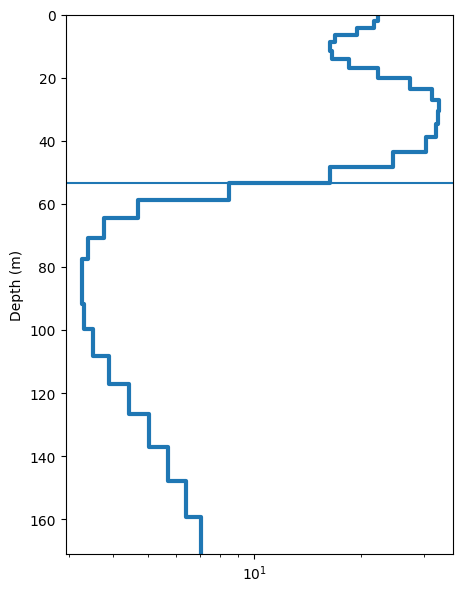

In [32]:
fig, ax = plt.subplots(1,1, figsize=(5, 7))
plot_1d_layer_model(thicknesses[:29], RHO_SHARP[i_sounding,:30], ax=ax, **{'linewidth':3})
xlim = ax.get_xlim()
ax.hlines(depth[ind], xlim[0], xlim[1])

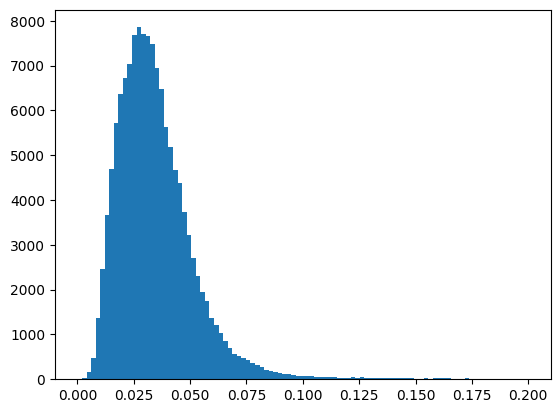

In [33]:
out = plt.hist(var_values, bins=np.linspace(0, 0.2, 100))

# Filter the estimated depth values 

In [34]:
inds = np.logical_and(var_values<0.125, depth_values<130)

(4327233.398, 4407778.522)

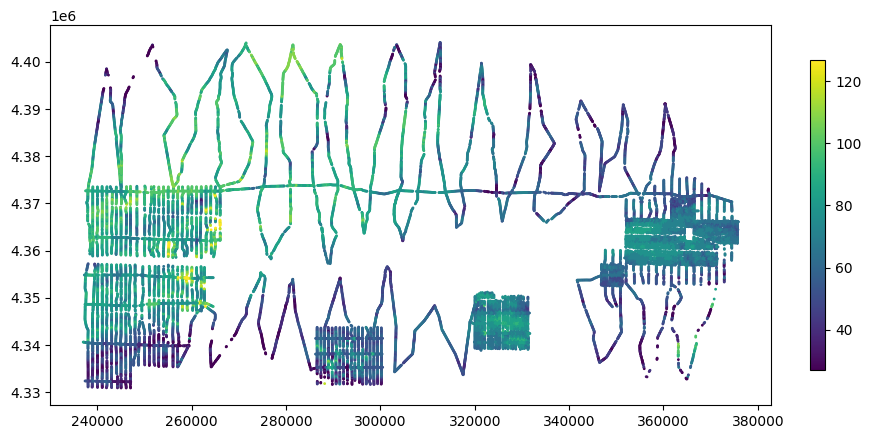

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
out = ax.scatter(xyz_aem[inds,:][::5,0], xyz_aem[inds,:][::5,1], c=depth_values[inds][::5], s=1)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_aspect(1)
cb = plt.colorbar(out, fraction=0.02)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [40]:
df_bedrock = pd.read_excel("../data/sediment_type/Bedrock.xlsx", skiprows=11)

# Then interpolate to fill in omitted values

In [41]:
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

In [42]:
f_bedrock_depth = LinearNDInterpolator(xyz_aem[inds,:2], depth_values[inds])
f_bedrock_depth_nearest = NearestNDInterpolator(xyz_aem[inds,:2], depth_values[inds])

In [43]:
z_bedrock_int = f_bedrock_depth(xyz_aem[:,:2])
inds_nan = np.isnan(z_bedrock_int)
z_bedrock_int[inds_nan] = f_bedrock_depth_nearest(xyz_aem[inds_nan,:2])

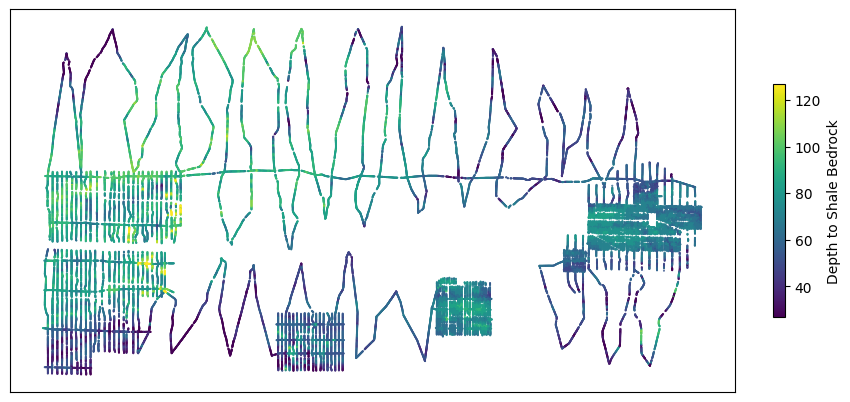

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
out = ax.scatter(xyz_aem[::3,0], xyz_aem[::3,1], c=z_bedrock_int[::3], s=0.2)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_aspect(1)
cb = plt.colorbar(out, fraction=0.015)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks([])
ax.set_yticks([])
cb.set_label("Depth to Shale Bedrock")

In [76]:
df = pd.DataFrame(data=np.c_[xyz_aem, z_bedrock_int], columns=['x', 'y', 'elevation', 'depth_to_bedrock'])
df.to_csv("bedrock_depth_from_aem.csv", index=False)